# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [293]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [294]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [295]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [296]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [297]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH

In [298]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [299]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(16512, 9) (16512, 1)
(4128, 9) (4128, 1)


## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [300]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

In [301]:
cat_columns

Index(['ocean_proximity'], dtype='object')

In [302]:
num_columns

Index(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income'],
      dtype='object')

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [303]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(16512, 9)
(16512, 9)


#### Encoding


Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

In [304]:
from sklearn.base import BaseEstimator, TransformerMixin
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

    def inverse_transform(self, X_transformed):
        X_original = X_transformed.copy()
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X_transformed[:, -1]
            X_original[:, bedrooms_ix] = X_transformed[:, rooms_ix] * bedrooms_per_room
            X_transformed = np.delete(X_transformed, -1, axis=1)
        
        population_per_household = X_transformed[:, -1]
        X_original[:, population_ix] = X_transformed[:, households_ix] * population_per_household
        X_transformed = np.delete(X_transformed, -1, axis=1)

        rooms_per_household = X_transformed[:, -1]
        X_original[:, rooms_ix] = X_transformed[:, households_ix] * rooms_per_household
        X_transformed = np.delete(X_transformed, -1, axis=1)

        return X_original


In [305]:

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(train_X.values)

In [306]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    train_X.columns.get_loc(c) for c in col_names] # get the column indices

In [307]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(train_X.columns)+["rooms_per_household", "population_per_household"],
    index=train_X.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
0,-118.04,33.99,47.0,2530.0,565.0,1262.0,509.0,3.6475,1H OCEAN,4.97053,2.479371
1,-122.2,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175,NEAR BAY,6.982955,2.386364
2,-118.25,34.09,52.0,3142.0,765.0,1728.0,682.0,3.1864,1H OCEAN,4.607038,2.533724
3,-117.99,33.7,25.0,2017.0,357.0,1063.0,369.0,4.0345,1H OCEAN,5.466125,2.880759
4,-120.88,37.52,2.0,1871.0,409.0,707.0,256.0,2.6103,INLAND,7.308594,2.761719


In [308]:
train_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.04,33.99,47.0,2530.0,565.0,1262.0,509.0,3.6475,1H OCEAN
1,-122.20,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175,NEAR BAY
2,-118.25,34.09,52.0,3142.0,765.0,1728.0,682.0,3.1864,1H OCEAN
3,-117.99,33.70,25.0,2017.0,357.0,1063.0,369.0,4.0345,1H OCEAN
4,-120.88,37.52,2.0,1871.0,409.0,707.0,256.0,2.6103,INLAND


In [309]:
## Transformation Pipelines(exercise 3)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

housing_num = train_X.drop("ocean_proximity", axis=1)
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)
housing_num_tr

array([[ 0.76042634, -0.76677882,  1.45527675, ..., -0.17865878,
        -0.06830011,  0.14522294],
       [-1.31569045,  1.02780974,  0.66033925, ...,  0.60567428,
        -0.07922436, -1.01387342],
       [ 0.65562237, -0.71992272,  1.8527455 , ..., -0.32032825,
        -0.06191606,  0.45243162],
       ...,
       [-1.2508118 ,  0.9153551 , -1.0090295 , ...,  0.21966371,
         0.13002783, -0.98086836],
       [-1.43047575,  1.0090673 ,  1.8527455 , ..., -0.79509632,
        -0.09768799,  1.64505846],
       [-1.07114785,  0.59673363, -1.0090295 , ...,  0.26508994,
         0.11158718, -0.67292928]])

In [310]:
# Get the original column names from the numerical DataFrame
original_column_names = list(housing_num.columns)

# Add the new column names created by the CombinedAttributesAdder
new_columns = ['rooms_per_household', 'population_per_household']
if num_pipeline.named_steps['attribs_adder'].add_bedrooms_per_room:
    new_columns.append('bedrooms_per_room')

# Combine the original and new column names
column_names = original_column_names + new_columns

# Convert the transformed data back to a DataFrame
housing_num_tr_df = pd.DataFrame(housing_num_tr, columns=column_names)

housing_num_tr_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room
0,0.760426,-0.766779,1.455277,-0.015030,0.120537,-0.137216,0.069540,-0.107653,-0.178659,-0.068300,0.145223
1,-1.315690,1.027810,0.660339,-0.761706,-0.982981,-1.050893,-0.976725,1.804227,0.605674,-0.079224,-1.013873
2,0.655622,-0.719923,1.852746,0.336212,0.695285,0.368454,0.613095,-0.369245,-0.320328,-0.061916,0.452432
3,0.785380,-0.902662,-0.293586,-0.309454,-0.477202,-0.353156,-0.370331,0.111902,0.014497,-0.021155,-0.560859
4,-0.656923,0.887241,-2.121942,-0.393247,-0.327768,-0.739461,-0.725370,-0.696080,0.732591,-0.035137,0.073273


In [311]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

features_transformer = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = features_transformer.fit_transform(train_X)
housing_prepared

array([[ 0.76042634, -0.76677882,  1.45527675, ...,  0.        ,
         0.        ,  0.        ],
       [-1.31569045,  1.02780974,  0.66033925, ...,  0.        ,
         1.        ,  0.        ],
       [ 0.65562237, -0.71992272,  1.8527455 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.2508118 ,  0.9153551 , -1.0090295 , ...,  0.        ,
         1.        ,  0.        ],
       [-1.43047575,  1.0090673 ,  1.8527455 , ...,  0.        ,
         1.        ,  0.        ],
       [-1.07114785,  0.59673363, -1.0090295 , ...,  0.        ,
         0.        ,  0.        ]])

In [312]:
# Get the column names from the numerical part
num_columns = column_names

# Get the column names from the categorical part
cat_columns = features_transformer.named_transformers_['cat'].get_feature_names_out(cat_attribs)

# Combine the column names
all_columns = np.concatenate((num_columns, cat_columns))

# Convert the transformed data back to a DataFrame
housing_prepared_df = pd.DataFrame(housing_prepared, columns=all_columns)

housing_prepared_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.760426,-0.766779,1.455277,-0.015030,0.120537,-0.137216,0.069540,-0.107653,-0.178659,-0.068300,0.145223,1.0,0.0,0.0,0.0,0.0
1,-1.315690,1.027810,0.660339,-0.761706,-0.982981,-1.050893,-0.976725,1.804227,0.605674,-0.079224,-1.013873,0.0,0.0,0.0,1.0,0.0
2,0.655622,-0.719923,1.852746,0.336212,0.695285,0.368454,0.613095,-0.369245,-0.320328,-0.061916,0.452432,1.0,0.0,0.0,0.0,0.0
3,0.785380,-0.902662,-0.293586,-0.309454,-0.477202,-0.353156,-0.370331,0.111902,0.014497,-0.021155,-0.560859,1.0,0.0,0.0,0.0,0.0
4,-0.656923,0.887241,-2.121942,-0.393247,-0.327768,-0.739461,-0.725370,-0.696080,0.732591,-0.035137,0.073273,0.0,1.0,0.0,0.0,0.0


In [313]:
housing_prepared_df.shape

(16512, 16)

**Dev notes(Encoding):**
<details>

    Some common practices followed in Categorical Feature Encoding are
    * For categorical variables with too many levels, target encoding can be done.
    * For fewer levels, one hot encoding can be done.
    * If one very dominant level is observed, binary encoding can be used.
    
    
</details>

## 3.2 Feature analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

Running the features transformer on the complete data

In [314]:
train_X = pd.DataFrame(
    features_transformer.fit_transform(train_X), 
    columns=all_columns
)

train_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.760426,-0.766779,1.455277,-0.015030,0.120537,-0.137216,0.069540,-0.107653,-0.178659,-0.068300,0.145223,1.0,0.0,0.0,0.0,0.0
1,-1.315690,1.027810,0.660339,-0.761706,-0.982981,-1.050893,-0.976725,1.804227,0.605674,-0.079224,-1.013873,0.0,0.0,0.0,1.0,0.0
2,0.655622,-0.719923,1.852746,0.336212,0.695285,0.368454,0.613095,-0.369245,-0.320328,-0.061916,0.452432,1.0,0.0,0.0,0.0,0.0
3,0.785380,-0.902662,-0.293586,-0.309454,-0.477202,-0.353156,-0.370331,0.111902,0.014497,-0.021155,-0.560859,1.0,0.0,0.0,0.0,0.0
4,-0.656923,0.887241,-2.121942,-0.393247,-0.327768,-0.739461,-0.725370,-0.696080,0.732591,-0.035137,0.073273,0.0,1.0,0.0,0.0,0.0


### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [315]:
train_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_household,population_per_household,bedrooms_per_room,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.760426,-0.766779,1.455277,-0.015030,0.120537,-0.137216,0.069540,-0.107653,-0.178659,-0.068300,0.145223,1.0,0.0,0.0,0.0,0.0
1,-1.315690,1.027810,0.660339,-0.761706,-0.982981,-1.050893,-0.976725,1.804227,0.605674,-0.079224,-1.013873,0.0,0.0,0.0,1.0,0.0
2,0.655622,-0.719923,1.852746,0.336212,0.695285,0.368454,0.613095,-0.369245,-0.320328,-0.061916,0.452432,1.0,0.0,0.0,0.0,0.0
3,0.785380,-0.902662,-0.293586,-0.309454,-0.477202,-0.353156,-0.370331,0.111902,0.014497,-0.021155,-0.560859,1.0,0.0,0.0,0.0,0.0
4,-0.656923,0.887241,-2.121942,-0.393247,-0.327768,-0.739461,-0.725370,-0.696080,0.732591,-0.035137,0.073273,0.0,1.0,0.0,0.0,0.0


In [316]:
out = eda.get_density_plots(train_X, cols=['housing_median_age', 'population'])
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [housing_median_age]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [317]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

In [318]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

p-value may not be accurate for N > 5000.


### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [319]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,households,total_bedrooms,0.972044,0.972044
1,latitude,longitude,-0.925628,0.925628
2,total_bedrooms,total_rooms,0.920203,0.920203
3,households,total_rooms,0.912943,0.912943
4,households,population,0.908202,0.908202
5,population,total_bedrooms,0.872036,0.872036
6,population,total_rooms,0.841843,0.841843
7,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,-0.608116,0.608116


In [320]:
# have hight correlation , but it is not causation
curated_columns = list(
    set(train_X.columns.to_list()) 
    - set([])
)

train_X = train_X[curated_columns]

out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,households,total_bedrooms,0.972044,0.972044
1,latitude,longitude,-0.925628,0.925628
2,total_bedrooms,total_rooms,0.920203,0.920203
3,households,total_rooms,0.912943,0.912943
4,households,population,0.908202,0.908202
5,population,total_bedrooms,0.872036,0.872036
6,population,total_rooms,0.841843,0.841843
7,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,-0.608116,0.608116


In [321]:
out = eda.get_bivariate_plots(train_X, x_cols=['population'], y_cols=['total_rooms'])
out

:HexTiles   [population,total_rooms]

In [322]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 34.6 s, sys: 40.1 s, total: 1min 14s
Wall time: 21.7 s


In [323]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [324]:
out = eda.get_target_correlation(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

In [325]:
train_y['median_house_value']

0        197100.0
1        366700.0
2        189800.0
3        229400.0
4        133600.0
           ...   
16507    175000.0
16508     83000.0
16509    247000.0
16510    316700.0
16511    253800.0
Name: median_house_value, Length: 16512, dtype: float64

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
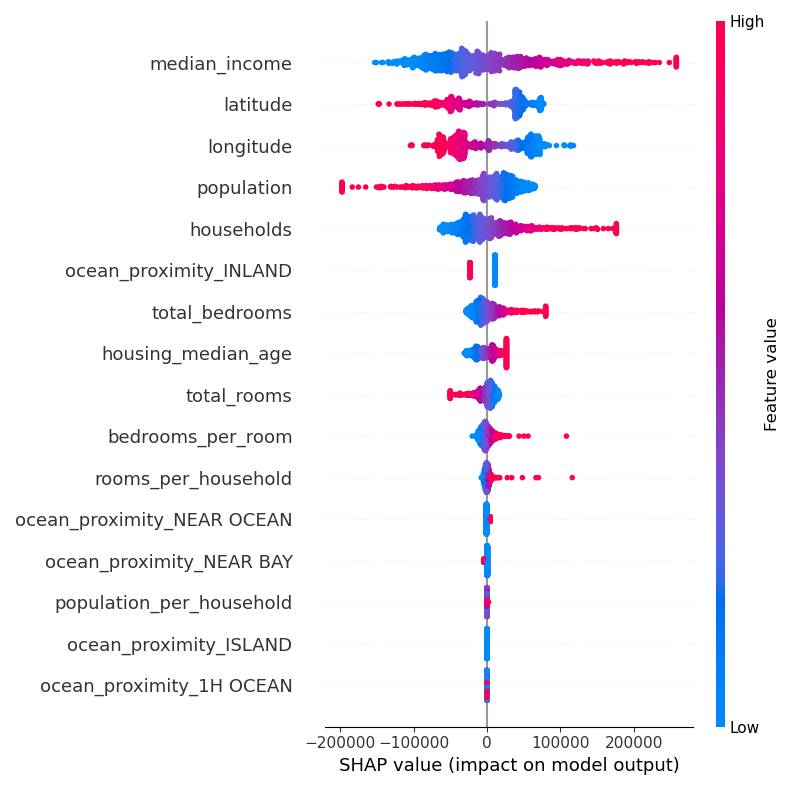

In [326]:
out = eda.get_feature_importances(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [327]:
reports.key_drivers(train_X,train_y, './key_drivers_report.html', y_continuous=True, quick=False)

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.

In [328]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html', y_continuous=True)

p-value may not be accurate for N > 5000.


In [329]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [330]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [331]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [332]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [333]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f1a25caaee0>,
                                     kw_args={'cols2keep': ['bedrooms_per_room',
                                                            'ocean_proximity_1H '
                                                            'OCEAN',
                                                            'ocean_proximity_INLAND',
                                                            'median_income',
                                                            'rooms_per_household',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'population_per_household',
                                                            'total_rooms',
                                                            'population',
                                                            'longitude',
                                                            'ocean_proximity_NEAR '
                                                            'BAY',
                                                            'ocean_proximity_ISLAND',
                                                            'housing_median_age']})),
                ('estimator', SKLStatsmodelOLS())])

In [334]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     2455.
Date:                Mon, 24 Apr 2023   Prob (F-statistic):               0.00
Time:                        17:49:19   Log-Likelihood:            -2.0744e+05
No. Observations:               16512   AIC:                         4.149e+05
Df Residuals:                   16499   BIC:                         4.150e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                    2.05e+05   5782.972     35.443      0.000    1.94e+05    2.16e+05
bedrooms_per_room           1.892e+04    689.386     27.442      0.000    1.76e+04    2.03e+04
ocean_proximity_1H OCEAN    2.223e+04   5832.070      3.812      0.000    1.08e+04    3.37e+04
ocean_proximity_INLAND     -4.685e+04   5855.580     -8.001      0.000   -5.83e+04   -3.54e+04
median_income               7.701e+04    741.364    103.872      0.000    7.56e+04    7.85e+04
rooms_per_household        -1471.8784    617.671     -2.383      0.017   -2682.581    -261.176
ocean_proximity_NEAR OCEAN  3.649e+04   5911.259      6.173      0.000    2.49e+04    4.81e+04
population_per_household   -1046.5837    553.467     -1.891      0.059   -2131.439      38.272
total_rooms                 3.706e+04   1249.720     29.654      0.000    3.46e+04    3.95e+04
population                   -3.1e+04   1211.603    -25.590      0.000   -3.34e+04   -2.86e+04
longitude                  -4384.2270    631.608     -6.941      0.000   -5622.247   -3146.207
ocean_proximity_NEAR BAY    2.045e+04   5994.335      3.412      0.001    8701.937    3.22e+04
ocean_proximity_ISLAND      1.726e+05   2.88e+04      5.987      0.000    1.16e+05    2.29e+05
housing_median_age          1.587e+04    624.020     25.435      0.000    1.46e+04    1.71e+04
==============================================================================
Omnibus:                     3839.465   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            24044.413
Skew:                           0.970   Prob(JB):                         0.00
Kurtosis:                       8.584   Cond. No.                     1.77e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.2e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [340]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])

test_X = pd.DataFrame(
    features_transformer.transform(test_X), 
    columns=all_columns
)
test_X = test_X[curated_columns]

In [341]:
all_columns

array(['longitude', 'latitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income',
       'rooms_per_household', 'population_per_household',
       'bedrooms_per_room', 'ocean_proximity_1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype=object)

In [342]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [343]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [344]:
residual_analysis.head()

,bedrooms_per_room,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,median_income,rooms_per_household,ocean_proximity_NEAR OCEAN,latitude,households,total_bedrooms,population_per_household,total_rooms,population,longitude,ocean_proximity_NEAR BAY,ocean_proximity_ISLAND,housing_median_age,prediction,actuals,forecast_flag
0,-0.214494,1.0,0.0,0.142367,-0.026724,0.0,-1.300938,0.562824,0.545851,0.226174,0.581851,2.097061,1.289437,0.0,0.0,-1.327004,163734.750652,134500.0,good
1,-0.569788,1.0,0.0,0.360786,0.132989,0.0,-0.780836,-0.477157,-0.523182,-0.023628,-0.357663,-0.467094,0.715510,0.0,0.0,0.580846,251341.702212,266000.0,good
2,-0.277384,1.0,0.0,-0.297706,-0.117784,0.0,-0.059252,-0.389183,-0.457086,-0.023004,-0.398986,-0.378114,-0.547128,0.0,0.0,-0.770548,186329.450664,163900.0,good
3,1.473676,0.0,1.0,-1.470647,-0.703364,0.0,1.383916,0.050689,0.123410,-0.181815,-0.420795,-0.680864,-0.956363,0.0,0.0,1.057808,100472.807677,137500.0,good
4,-0.465152,1.0,0.0,0.408215,0.125355,0.0,-0.668381,-0.131544,-0.155343,-0.001079,0.001614,-0.033043,0.495921,0.0,0.0,0.580846,257780.472374,201500.0,good


In [345]:
residual_analysis.hvplot.kde(y="median_income",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="median_income",
                                title=f'median_income(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [median_income]   (Density)

- From the above plot we can infer that the higher "under predictions" are happening for median_income <> 2.

# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [346]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

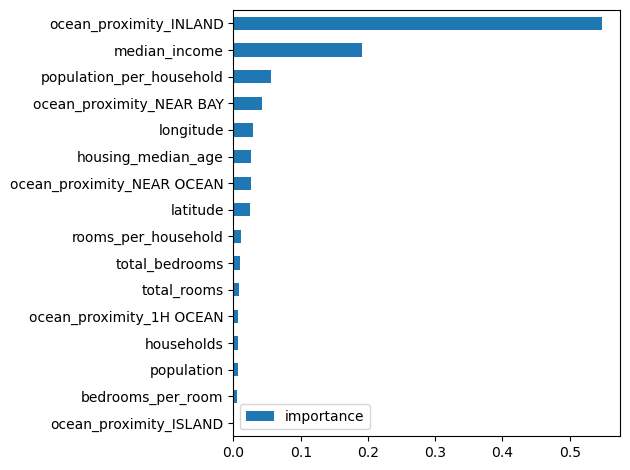

In [347]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

In [348]:
list(imp.index)

['ocean_proximity_ISLAND',
 'bedrooms_per_room',
 'population',
 'households',
 'ocean_proximity_1H OCEAN',
 'total_rooms',
 'total_bedrooms',
 'rooms_per_household',
 'latitude',
 'ocean_proximity_NEAR OCEAN',
 'housing_median_age',
 'longitude',
 'ocean_proximity_NEAR BAY',
 'population_per_household',
 'median_income',
 'ocean_proximity_INLAND']

##### Pipeline build based on new importance features

In [349]:
# let's find features for some decent defaults
imp_features = list(imp.index)

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [350]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/prabhat/miniconda3/envs/regression-dev-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/prabhat/miniconda3/envs/regression-dev-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/prabhat/miniconda3/envs/regression-dev-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/prabhat/miniconda3/envs/regression-dev-dev/lib/python3.9/site-packages/xgboost/data.py

0.8246612506259754
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 15.1 s, sys: 129 ms, total: 15.2 s
Wall time: 3min 16s


#### Pipeline Build using the best estimator

In [351]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7f1a25caaee0>,
                                     kw_args={'cols2keep': ['ocean_proximity_ISLAND',
                                                            'bedrooms_per_room',
                                                            'population',
                                                            'households',
                                                            'ocean_proximity_1H '
                                                            'OCEAN',
                                                            'total_rooms',
                                                            'total_bedrooms',
                                                            'rooms_per_household',
                                                            'latitude',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'housing_median_age',
                                                            'longitude',
                                                            'ocean_p...
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [352]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [353]:
train_y

,median_house_value
0,197100.0
1,366700.0
2,189800.0
3,229400.0
4,133600.0
...,...
16507,175000.0
16508,83000.0
16509,247000.0
16510,316700.0


In [355]:
model_pipelines = [reg_ppln, xgb_pipeline_final]
model_comparison_report = RegressionComparison(models=model_pipelines,x=train_X, y=train_y)
#metrics = model_comparison_report.get_report(file_path='regression_comparison')

In [358]:
#model_comparison_report.performance_metrics

: 

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing LM model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Linear Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat